In [1]:
import pickle
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import SimpleImputer
import matplotlib.pyplot as plt
from sklearn_pandas import DataFrameMapper
import seaborn as sns

# Read the pickled DataFrame
with open('data/consolidated_pat_tbl_tv.pickle', 'rb') as file:
    consolidated_pat_tbl = pickle.load(file)

In [2]:
# OneHotEncode race (ethnicity)!
encoder = OneHotEncoder(sparse_output=False)
race_enc = encoder.fit_transform(consolidated_pat_tbl[['race']])
mod_df = consolidated_pat_tbl.drop('race' , axis = 1)
mod_df = pd.concat([mod_df , pd.DataFrame(
    race_enc , 
    columns = consolidated_pat_tbl[['race']].drop_duplicates().sort_values('race').values.T[0]
    )
] , axis = 1)

In [3]:
def train_test_splitter_tv(df , test_size = 0.2 , val_size = 0.2 , patient_col = 'subject_id'):
    # get all patients
    pats = df[patient_col].unique()
    # inplace shuffle
    np.random.shuffle(pats)

    # get splits
    test_pats = pats[:int(test_size*len(pats))]
    val_pats = pats[int(test_size*len(pats)):int(test_size*len(pats))+int(val_size*len(pats))]
    train_pats = pats[int(test_size*len(pats))+int(val_size*len(pats)):]

    # allocate
    df_test = df[df['subject_id'].isin(test_pats)]
    df_val = df[df['subject_id'].isin(val_pats)]
    df_train = df[df['subject_id'].isin(train_pats)]
    
    # check
    assert df_train.subject_id.nunique() + df_test.subject_id.nunique() + df_val.subject_id.nunique() == df.subject_id.nunique()
    return df_train , df_test , df_val

df_train , df_test , df_val = train_test_splitter_tv(mod_df)

In [6]:
def impute(df):
    _columns = df.columns.astype('str')
    df.columns = _columns

    # Imputation
    imputer = SimpleImputer(strategy = 'most_frequent')
    df = pd.DataFrame(imputer.fit_transform(df) , columns = _columns)

    # Check for null
    assert np.round(df.notnull().sum()/len(df)).sum() == df.shape[1]

    # # name change
    # df.rename(columns = {'50907':'cholesterol' , '50983':'sodium' , '51133':'lymphocyte' , '51222':'hemoglobin'} , inplace = True)

    return df

# use on train test val data
df_train = impute(df_train)
df_test = impute(df_test)
df_val = impute(df_val)

In [5]:
def scaling(df):
    # Scaling
    scaler = StandardScaler()
    scaled_columns = [
        'cholesterol', 'sodium', 'lymphocyte', 'hemoglobin',
        'temperature', 'heartrate', 'resprate', 'o2sat', 'sbp', 'dbp'
        ]

    unscaled_columns = ['acebutolol', 'amlodipine', 'atenolol', 'benazepril', 'candesartan',
        'captopril', 'diltiazem', 'felodipine', 'irbesartan', 'lisinopril',
        'moexipril', 'nadolol', 'nebivolol', 'nicardipine', 'nifedipine',
        'olmesartan', 'propranolol', 'quinapril', 'ramipril', 'telmisartan',
        'trandolapril', 'valsartan', 'verapamil', 'ASIAN', 'BLACK', 'HISPANIC', 'NATIVE',
        'OTHER', 'WHITE']

    scale = [([col], StandardScaler()) for col in scaled_columns]
    no_scale = [(col, None) for col in unscaled_columns]

    x_mapper = DataFrameMapper(scale + no_scale)
    
    # scale data
    x = pd.DataFrame(x_mapper.fit_transform(df).astype('float32') , 
                        columns = scaled_columns + unscaled_columns
                        )
    x = pd.concat([x , df[['subject_id', 'charttime']]] , 
                        axis = 1
                        )
    y = df[['subject_id','time_to_event','death']].drop_duplicates()
    return x , y

# Scale
x_train , y_train = scaling(df_train)
x_test , y_test = scaling(df_test)
x_val , y_val = scaling(df_val)

In [42]:
def feature_reshape(df, group_column = 0):
    '''
    Convert to 3D array
    '''
    # convert to numpy
    df_arr = df.to_numpy()

    # Step 1: Sort the array based on the group_column
    sorted_data = df_arr[df_arr[:, group_column].argsort()]

    # Step 2: Find unique values in the group_column
    group_values, group_counts = np.unique(sorted_data[:, group_column], return_counts=True)

    # Step 3: Use np.split() to split the sorted_data into separate arrays based on the unique values
    grouped_data = np.split(sorted_data, np.cumsum(group_counts)[:-1])

    # Step 4: Reshape the resulting arrays into a 3D matrix
    result = np.array(grouped_data , dtype = 'object')

    return result

In [43]:
# Create variable length 3D representations
x_train_reshape = feature_reshape(x_train , group_column = -2)
x_test_reshape = feature_reshape(x_test , group_column = -2)
x_val_reshape = feature_reshape(x_val , group_column = -2)

In [48]:
x_train_reshape[10000]

array([[-1.0922335386276245, -0.4225929081439972, -0.1838805377483368,
        0.1471981704235077, -1.160187840461731, -1.126474142074585,
        -1.1419631242752075, -1.1326351165771484, -1.1421821117401123,
        -0.649154007434845, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,
        0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,
        0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 16855142,
        datetime.date(2138, 10, 22)],
       [-1.0922335386276245, -0.4225929081439972, -0.1838805377483368,
        0.17060834169387817, -1.160187840461731, -1.126474142074585,
        -1.1419631242752075, -1.1326351165771484, -1.1421821117401123,
        -0.649154007434845, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,
        0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,
        0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 16855142,
        datetime.date(2138, 6, 25)],
       [-1.0922335386276245, -0.4536011517047882, -0.1838805377483368,
        0.17060834169387817, -1.160

In [ ]:
def check_var(df):
    zero_var_cols = []
    # Check which columns have zero variance
    for _col in df.columns[:-2]:
        var = df[_col].var()
        if var == 0:
            zero_var_cols.append(_col)
    return zero_var_cols

zero_var_cols = check_var(x_train)

# Drop the cols
x_train.drop(zero_var_cols, axis = 1, inplace = True)
x_test.drop(zero_var_cols, axis = 1, inplace = True)
x_val.drop(zero_var_cols, axis = 1, inplace = True)

In [ ]:
# Pickle the DataFrame
with open('data/x_train.pickle', 'wb') as file:
    pickle.dump(x_train, file)

with open('data/x_val.pickle', 'wb') as file:
    pickle.dump(x_val, file)

with open('data/x_test.pickle', 'wb') as file:
    pickle.dump(x_test, file)

<Axes: >

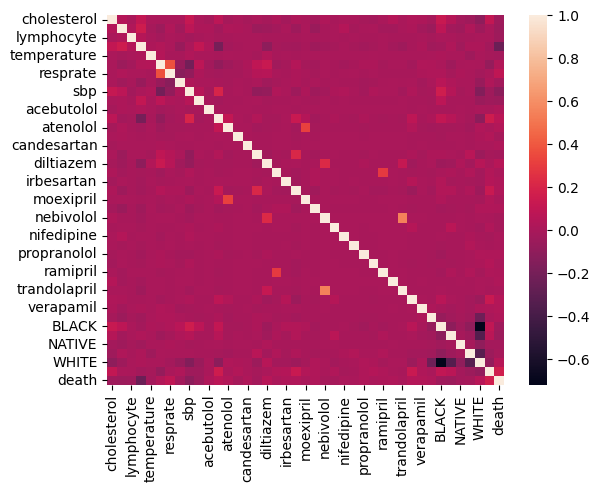

In [ ]:
sns.heatmap(x_train.corr())